In [9]:
import numpy as np
from numpy import loadtxt
from matplotlib import pyplot as plt
%matplotlib inline
from rctorchprivate import *

import pickle
from scipy.integrate import solve_ivp as rk
import autograd
from autograd.numpy import cos, sin
solve_ivp = rk


In [10]:
!pwd

/Users/hayden/Desktop/RcTorch/RcTorch-private


## helper functions

In [11]:
def myMSE(prediction,target):
    return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

def residuals(prediction,target):
    return (target.flatten() - prediction.flatten())

def plotResults(trainlen, testlen, data, yfit, yhat, resTrain, resTest):
    """
    Arguments:
        trainlen: the length of the training set
        testlen: the length of the test set
        data: the entire dataset
        yfit: the prediction of the RC on the training set 
        yhat: the prediction of the RC on an unseen test set
        resTrain: training residuals
        resTest: test residuals
    """
    #data plot
    plt.figure(figsize=(14,6))
    plt.subplot(2,1,1)
    plt.plot(range(0,trainlen+testlen),data[:(trainlen+testlen)],'k',  linewidth=2, label="data")
    plt.plot(range(0,trainlen),yfit,'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), yhat,'--r', linewidth=2,  alpha=1, label="test")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('x')
    plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)

    
    #Residuals plot
    plt.subplot(2,1,2)
    plt.plot(range(0,trainlen),resTrain,'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), resTest,'--r', linewidth=2,  alpha=1, label="test")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('Residuals')



# simple mass spring/harmonic oscillator

In [12]:
def mass_spring(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, noise_std, seed):
    """1-body mass spring system"""

    def hamiltonian_fn(coords):
        q, p = np.split(coords, 2)

        H = (p ** 2) / 2 + (q ** 2) / 2  # spring hamiltonian (linear oscillator)
        return H

    def dynamics_fn(t, coords):
        dcoords = autograd.grad(hamiltonian_fn)(coords)
        dqdt, dpdt = np.split(dcoords, 2)
        S = np.concatenate([dpdt, -dqdt], axis=-1)
        return S

    def get_trajectory(t_span=[0, 3], timescale=0.1, ssr=sub_sample_rate, radius=None, y0=None, noise_std=0.1,
                       **kwargs):

        # get initial state
        if y0 is None:
            y0 = np.random.rand(2) * 2 - 1
        if radius is None:
            radius = np.sqrt(np.random.uniform(0.5, 4.5))
        y0 = y0 / np.sqrt((y0 ** 2).sum()) * (radius)

        spring_ivp = rk(lambda t, y: dynamics_fn(t, y), t_span, y0,
                        t_eval=np.arange(0, t_span[1], timescale),method='DOP853',rtol=1e-12,
                        )

        accum = spring_ivp.y.T
        ssr = int(ssr / timescale)
        accum = accum[::ssr]

        daccum = [dynamics_fn(None, accum[i]) for i in range(accum.shape[0])]
        energies = []
        for i in range(accum.shape[0]):
            energies.append(np.sum(hamiltonian_fn(accum[i])))

        return accum, np.array(daccum), energies

    def get_dataset(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, seed=seed, test_split=0.5, **kwargs):
        data = {'meta': locals()}

        # randomly sample inputs
        np.random.seed(seed)
        data = {}
        ssr = int(sub_sample_rate / dt)

        xs, dxs, energies, ks, ms = [], [], [], [], []
        for s in range(num_trajectories):
            x, dx, energy = get_trajectory(t_span=[0, T_max], timescale=dt, ssr=sub_sample_rate)

            x += np.random.randn(*x.shape) * noise_std
            dx += np.random.randn(*dx.shape) * noise_std

            xs.append(x)
            dxs.append(dx)
            energies.append(energy)
            ks.append([1])
            ms.append([1])

        data['x'] = np.concatenate(xs)
        data['dx'] = np.concatenate(dxs)
        data['energy'] = np.concatenate(energies)
        data['ks'] = np.concatenate(ks)
        data['mass'] = np.concatenate(ms)

        f = open(name + ".pkl", "wb")
        pickle.dump(data, f)
        f.close()

        return data

    return get_dataset(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate)


The time series consist of  5000  points.


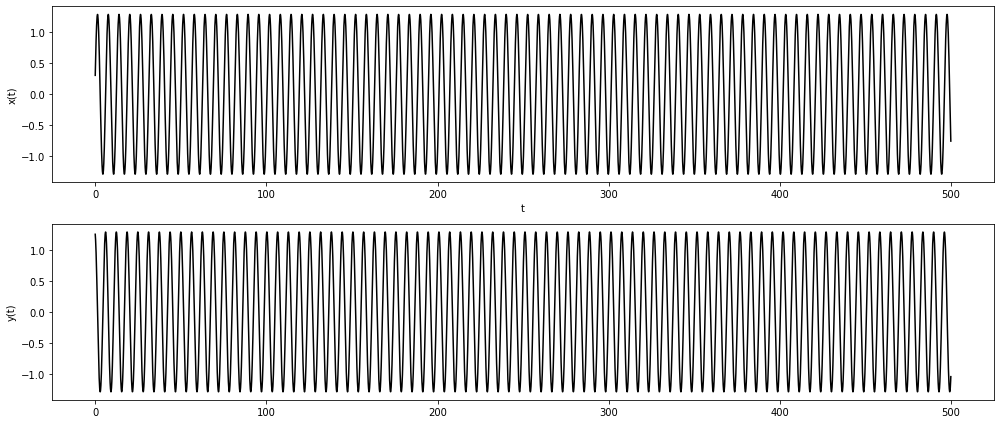

In [13]:
Tmax = 500
data = mass_spring(name = 'test', num_trajectories = 1, NUM_PARTS = 1,
                   T_max=Tmax, dt = 0.1, sub_sample_rate = 0.1, noise_std = 0, seed =3)
#loadtxt("data/HenonHeiles/t.dat"
xdata = data['x'][:,0]#loadtxt("data/HenonHeiles/x.dat")
ydata = data['x'][:,1]#loadtxt("data/HenonHeiles/y.dat")
#assert False, xdata.shape
tdata = np.arange(0,Tmax,0.1)

N = len(tdata)
print("The time series consist of ", N, " points.")

plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(tdata,xdata,'k')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(2,1,2)
plt.plot(tdata,ydata,'k')
plt.ylabel('y(t)')
plt.tight_layout()



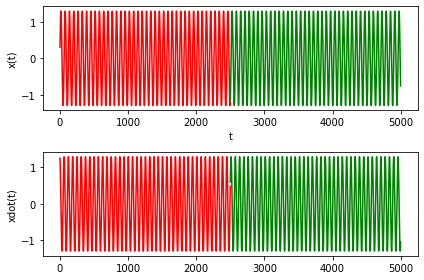

In [14]:
trainlen = int(0.8*N)
testlen  = int(0.2*N)
trainlen = int(0.5*N)
testlen  = int(0.5*N)


# Input  data equivalents:
#ttrain = np.ones(trainlen)
#ttest=np.ones(testlen)

# ttrain = tdata[:trainlen]
# ttest  = tdata[trainlen:trainlen+testlen]

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]

# plt.figure(figsize=(14,2))
# plt.plot(range(0,trainlen), xtrain,'r')
# plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')


plt.subplot(2,1,1)
plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(2,1,2)
plt.plot(range(0,trainlen), ytrain,'r')
plt.plot(range(trainlen,trainlen+testlen), ytest,'-g')
plt.ylabel('xdot(t)')
plt.tight_layout()




# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

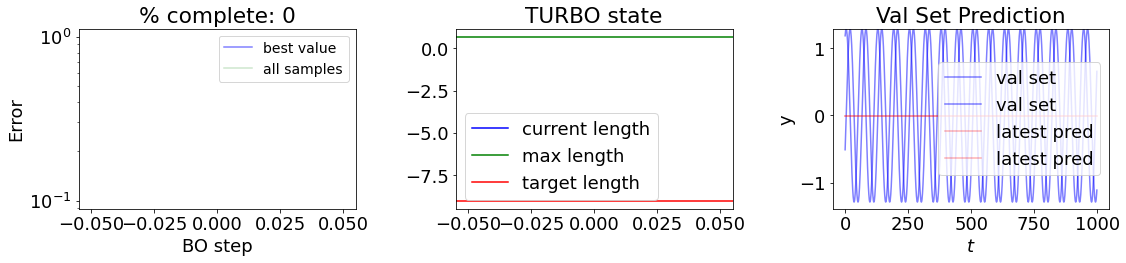

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fe8484f3d30> (for post_execute):


KeyboardInterrupt: 

In [17]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 200,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = 0, 
                            scoring_method = "mse", interactive = True, 
                            batch_size = 1, cv_samples = 4, initial_samples = 20, 
                            subsequence_length = int(ytrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 10,
                            n_inputs = 1, n_outputs = 2,
                            #activation_function = torch.sin,
                            #act_f_prime = torch.cos
                            
                
                           )
#optimize:

train_target = np.concatenate([xtrain.reshape(-1,1),ytrain.reshape(-1,1)], 1)
y_train_noise = ytrain.reshape(-1,1) + np.random.normal(loc = 0, scale = 0.1, size = ytrain.reshape(-1,1).shape)
x_train_noise = xtrain.reshape(-1,1) + np.random.normal(loc = 0, scale = 0.1, size = xtrain.reshape(-1,1).shape)

y_test_noise = ytest.reshape(-1,1) + np.random.normal(loc = 0, scale = 0.1, size = ytest.reshape(-1,1).shape)
x_test_noise = xtest.reshape(-1,1) + np.random.normal(loc = 0, scale = 0.1, size = xtest.reshape(-1,1).shape)


train_target2 = np.concatenate([y_train_noise, x_train_noise], 1)
test_target2 = np.concatenate([y_test_noise, x_test_noise], 1)

test_target = np.concatenate([xtest.reshape(-1,1),ytest.reshape(-1,1)],1) #x = train_target2,

optimized_hyper_params = esn_cv.optimize(y = train_target,  n_trust_regions = 2, max_evals = 200)

In [18]:
hps={'n_nodes': 1000,
 'connectivity': 0.1550854554184032,
 'spectral_radius': 1.4053781032562256,
 'regularization': 7.968441458750363,
 'leaking_rate': 0.21928098797798157,
 'bias': 0.21907640993595123}


esn = EchoStateNetwork(**hps, 
                       random_state = 209, 
                       feedback = 0, 
                       id_ = 10,
                       n_inputs = 2,
                       n_outputs = 2)

fit = esn.fit(y = train_target, X = train_target2, burn_in = 0) #, X = target[:-1])

scoreTest, xhat, _ = esn.test(y = test_target, X = test_target2, )


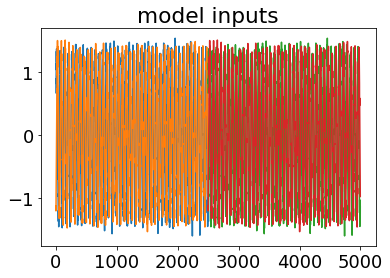

In [19]:
plt.title('model inputs')
xlen = len(xtest)
plt.plot(list(range(xlen)), test_target2)
plt.plot(list(range(xlen -1 , xlen - 1+ len(xhat))), test_target2)

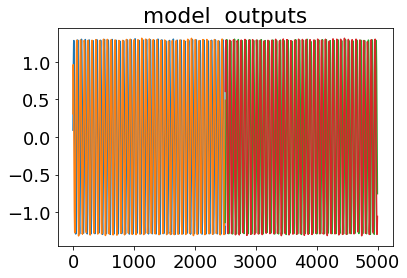

In [20]:
plt.title('model  outputs')
xlen = len(xtrain)
plt.plot(list(range(xlen)), fit)
len(xtrain)
plt.plot(list(range(xlen -1 , xlen - 1+ len(xhat))), xhat)

In [ ]:
esn.LinIn.weight.shape, esn.LinOut.weight.shape, esn.LinOut.bias.shape

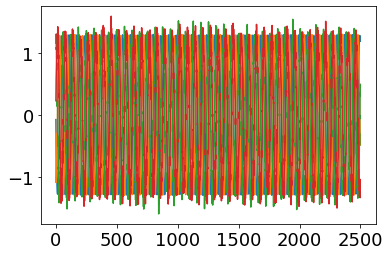

In [21]:
hyper_params={'n_nodes': 1000,
 'connectivity': 0.1550854554184032,
 'spectral_radius': 1.4053781032562256,
 'regularization': 7.968441458750363,
 'leaking_rate': 0.99,#0.21928098797798157,
 'bias': 0.21907640993595123}


esn = EchoStateNetwork(**hyper_params, 
                       random_state = 209, 
                       feedback = False, 
                       id_ = 10,
                       n_inputs = 2,
                       n_outputs = 2)

fit = esn.fit(y = train_target, X = train_target2, burn_in = 0) #, X = target[:-1])



#scoreTest, xhat, _ = esn.test(y = test_target, X = test_target2)
plt.plot(fit*-1)
plt.plot(train_target2)
#plt.plot(xhat)

In [22]:
hi = torch.ones(1000).view(-1,1)
bye = [hi, hi]
torch.hstack(bye).shape

torch.Size([1000, 2])

In [23]:
esn._output_means, esn._output_stds


(tensor([ 0.0029, -0.0057]), tensor([0.9132, 0.9112]))

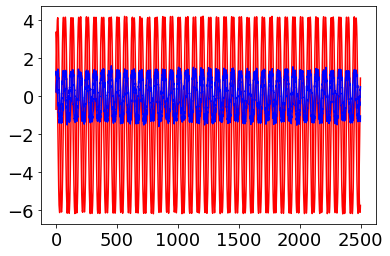

In [24]:
plt.plot(fit*4 - 1, color = 'red'); plt.plot(train_target2, color = "blue")

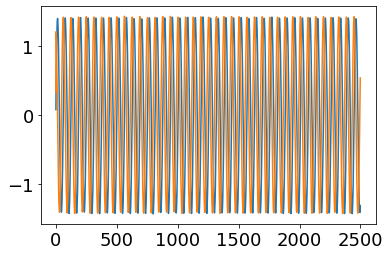

In [25]:
plt.plot(esn.LinOut(esn.extended_states).detach())

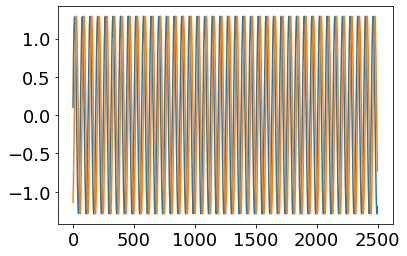

In [26]:
hyper_params={'n_nodes': 1000,
 'connectivity': 0.1550854554184032,
 'spectral_radius': 1.4053781032562256,
 'regularization': 7.968441458750363,
 'leaking_rate': 0.21928098797798157,
 'bias': 0.21907640993595123}


esn = EchoStateNetwork(**hyper_params, 
                       random_state = 209, 
                       feedback = True, 
                       id_ = 10,
                       n_inputs = 1,
                       n_outputs = 1)

fit = esn.fit(y = xtrain.reshape(-1,1), burn_in = 0) #, X = target[:-1])

scoreTest, xhat, _ = esn.test(y = xtest.reshape(-1,1))
plt.plot(fit)
plt.plot(xhat)

In [ ]:
plt.plot(esn.LinOut.weight.detach().T)

In [ ]:
plt.plot(esn.extended_states[:,:10])
esn.extended_states[:,0].mean(), esn.extended_states[:,1].mean()

In [ ]:
np.mean(xfit), np.std(xfit)

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(xfit)
plt.plot(test_target, alpha = 0.4)

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(xhat)
plt.plot(test_target, alpha = 0.4)

In [ ]:


# MSE in the training and testing
scoreTrain = myMSE(xfit,train_target)
scoreTest = myMSE(xhat,test_target)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit, xtrain);
resTest = residuals(xhat, xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

In [ ]:
state_ = torch.ones(1000)
hi = torch.zeros(2)

In [ ]:
cat([hi.view(-1,), state_], axis = 0)

In [ ]:
esn.LinOut.weight.shape, esn.LinIn.weight.shape

###  Data: <a href='https://en.wikipedia.org/wiki/Hénon–Heiles_system'>The Henon-Heiles System</a>

In [8]:
import pickle
from scipy.integrate import solve_ivp as rk
import autograd
from autograd.numpy import cos, sin
solve_ivp = rk
import numpy as np
def heinon_heiles(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, noise_std, seed):
    """heinon heiles data generator"""

    def hamiltonian_fn(coords):
        x, y, px, py = np.split(coords, 4)
        lambda_ = 1
        H = 0.5 * px ** 2 + 0.5 * py ** 2 + 0.5 * (x ** 2 + y ** 2) + lambda_ * (
                (x ** 2) * y - (y ** 3) / 3)
        return H

    def dynamics_fn(t, coords):
        dcoords = autograd.grad(hamiltonian_fn)(coords)
        dxdt, dydt, dpxdt, dpydt = np.split(dcoords, 4)
        S = np.concatenate([dpxdt, dpydt, -dxdt, -dydt], axis=-1)
        return S

    def get_trajectory(t_span=[0, 3], timescale=0.01, ssr=sub_sample_rate, radius=None, y0=None, noise_std=0.1,
                       **kwargs):

        # get initial state
        x = np.random.uniform(0, .4)
        y = np.random.uniform(0, .4)
        px = np.random.uniform(-.3, .3)
        py = np.random.uniform(-.3, .3)

        y0 = np.array([x, y, px, py])

        spring_ivp = rk(lambda t, y: dynamics_fn(t, y), t_span, y0,
                        t_eval=np.arange(0, t_span[1], timescale),
                        rtol=1e-12, method='DOP853')
        accum = spring_ivp.y.T
        print(accum.shape)
        ssr = int(ssr / timescale)
        accum = accum[::ssr]
        daccum = [dynamics_fn(None, accum[i]) for i in range(accum.shape[0])]
        energies = []
        for i in range(accum.shape[0]):
            energies.append(np.sum(hamiltonian_fn(accum[i])))

        return accum, np.array(daccum), energies

    def get_dataset(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, seed=seed, test_split=0.5,
                    **kwargs):
        data = {'meta': locals()}

        # randomly sample inputs
        np.random.seed(seed)
        data = {}
        ssr = int(sub_sample_rate / dt)

        xs, dxs, energies, ks, ms = [], [], [], [], []
        for s in range(num_trajectories):
            x, dx, energy = get_trajectory(t_span=[0, T_max], timescale=dt, ssr=sub_sample_rate)

            x += np.random.randn(*x.shape) * noise_std
            dx += np.random.randn(*dx.shape) * noise_std

            xs.append(x)
            dxs.append(dx)
            energies.append(energy)
            ks.append([1])
            ms.append([1])

        data['x'] = np.concatenate(xs)
        data['dx'] = np.concatenate(dxs)
        data['energy'] = np.concatenate(energies)
        data['ks'] = np.concatenate(ks)
        data['mass'] = np.concatenate(ms)

        f = open(name + ".pkl", "wb")
        pickle.dump(data, f)
        f.close()

        return data

    return get_dataset(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate)


In [9]:
data = heinon_heiles('test',1,1,500,0.1,0.1,0,3)

(5000, 4)


In [10]:
data['x'].shape

(5000, 4)

The time series consist of  5000  points.


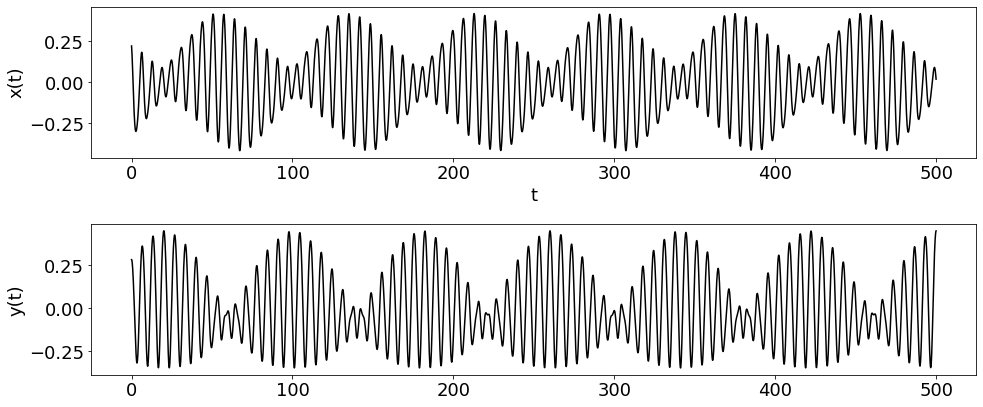

In [11]:
# lines = loadtxt("filename.dat", comments="#", delimiter=",", unpack=False)
tdata = np.arange(0,500,0.1)#loadtxt("data/HenonHeiles/t.dat")
xdata = data['x'][:,0]#loadtxt("data/HenonHeiles/x.dat")
ydata = data['x'][:,1]#loadtxt("data/HenonHeiles/y.dat")

N = len(tdata)
print("The time series consist of ", N, " points.")

plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(tdata,xdata,'k')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(2,1,2)
plt.plot(tdata,ydata,'k')
plt.ylabel('y(t)')
plt.tight_layout()



#### Short range forecast

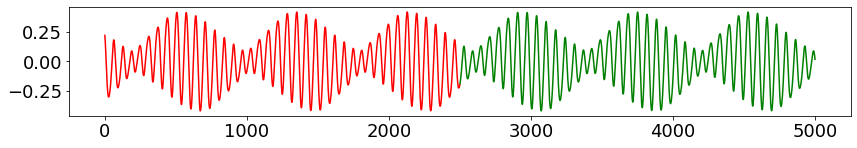

In [12]:
trainlen = int(0.8*N)
testlen  = int(0.2*N)
trainlen = int(0.5*N)
testlen  = int(0.5*N)


# Input  data equivalents:
#ttrain = np.ones(trainlen)
#ttest=np.ones(testlen)

# ttrain = tdata[:trainlen]
# ttest  = tdata[trainlen:trainlen+testlen]

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]

plt.figure(figsize=(14,2))

plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

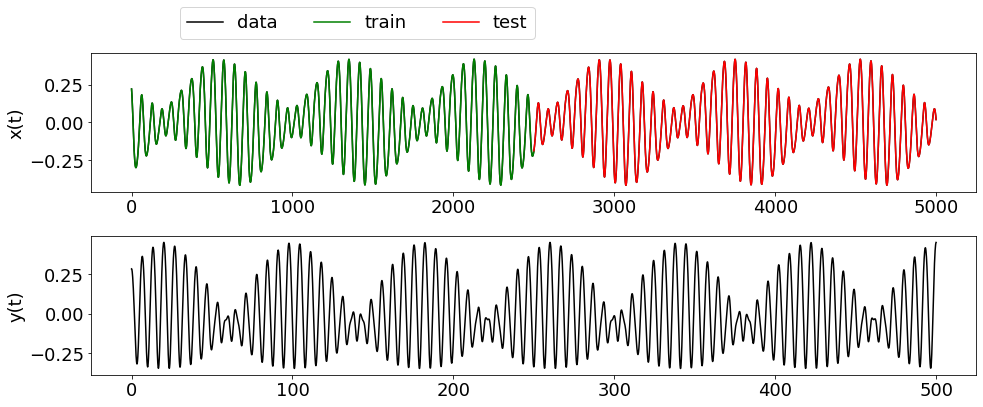

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(range(0,trainlen+testlen),xdata,'k',label='data')
plt.plot(range(0,trainlen), xtrain,'g',label='train')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-r',label='test')
plt.ylabel('x(t)')
plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)
plt.subplot(2,1,2)
plt.plot(tdata,ydata,'k')
plt.ylabel('y(t)')
plt.tight_layout()


plt.tight_layout()

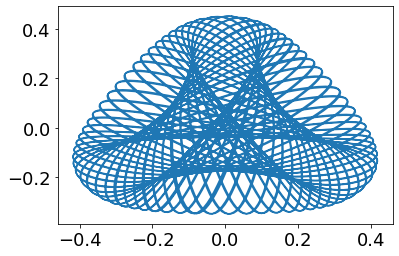

In [14]:
plt.plot(xdata,ydata)

# RcTorch pure prediction

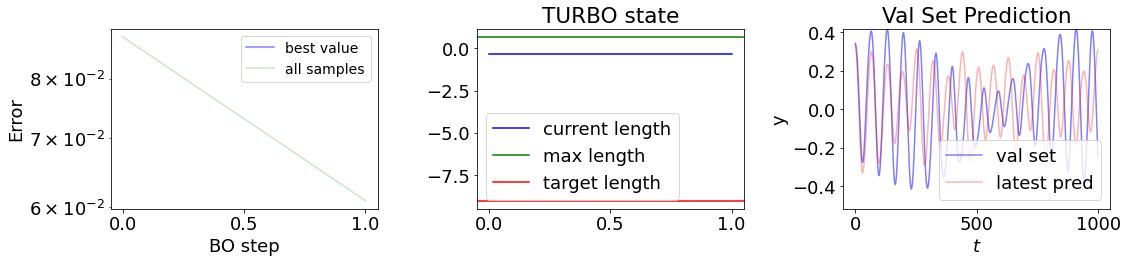

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb2e0d90d30> (for post_execute):


KeyboardInterrupt: 

In [17]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 1000,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "mse", interactive = True, 
                            batch_size = 1, cv_samples = 4, initial_samples = 20, 
                            subsequence_length = int(ytrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 10,
                            n_inputs = 1, n_outputs = 1)
#optimize:
optimized_hyper_params = esn_cv.optimize(y =xtrain.reshape(-1,1))

In [ ]:
optimized_hyper_params

In [ ]:
hyper_params={'n_nodes': 1000,
 'connectivity': 0.1550854554184032,
 'spectral_radius': 1.4053781032562256,
 'regularization': 7.968441458750363,
 'leaking_rate': 0.21928098797798157,
 'bias': 0.21907640993595123}


esn = EchoStateNetwork(**optimized_hyper_params, 
                       random_state = 209, 
                       feedback = True, 
                       id_ = 10,
                       backprop = False)
#esn.fit
fit = esn.train(y = np.concatenate([xtrain.reshape(-1,1),ytrain.reshape(-1,1)],1), X = np.concatenate([xtrain.reshape(-1,1),ytrain.reshape(-1,1)],1))

In [ ]:
np.concatenate([xtrain.reshape(-1,1),ytrain.reshape(-1,1)],1)

In [ ]:
optimized_hyper_params

In [ ]:
esn

In [ ]:
#esn.LinOut.weight.shape
sns.heatmap(esn.LinOut.weight.data)

In [ ]:
optimized_hyper_params

In [ ]:
esn = EchoStateNetwork(**hyper_params, random_state = 209, feedback = 1)
xfit = esn.train(y = xtrain)
print(xfit[0].shape)
xfit = xfit.reshape(-1)
scoreTest, xhat = esn.test(y = xtest.reshape(-1,1))


# MSE in the training and testing
scoreTrain = myMSE(xfit,xtrain)
scoreTest = myMSE(xhat,xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit, xtrain);
resTest = residuals(xhat, xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

In [ ]:
plt.plot(esn.state[:,1:5]);

#### Long range forecast (inference)

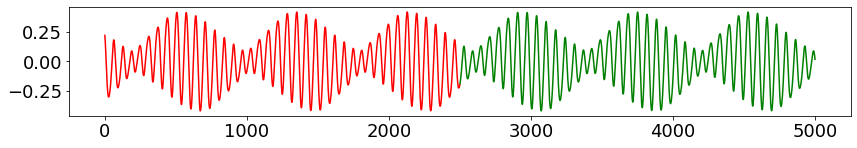

In [18]:
trainlen = int(0.5*N)
testlen  = int(0.5*N)

# Input  data
ttrain = np.ones(trainlen)
ttest=np.ones(testlen)

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]


plt.figure(figsize=(14,2))
plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

## RcTorch Observers Solution

In [ ]:
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 1000,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }
esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = False, 
                            scoring_method = "nmse", interactive = True, 
                            batch_size = 1, cv_samples = 2, initial_samples = 50, 
                            subsequence_length = int(ytrain.shape[0] * 0.9),
                            random_seed = 123)

optimized_hyper_params = esn_cv.optimize(y = xtrain.reshape(-1,1), x = ytrain.reshape(-1,1))

In [ ]:
esn = EchoStateNetwork(**optimized_hyper_params, random_state = 123, feedback = False)
xfit = esn.train(y = xtrain, X = ytrain)
xfit = xfit.reshape(-1)
#scoreTrain, yfit = esn.test(y = ytrain)
scoreTest, xhat = esn.test(y = xtest, x = ytest)

# MSE in the training and testing
scoreTrain = myMSE(xfit, xtrain)
scoreTest = myMSE(xhat, xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit,xtrain);
resTest = residuals(xhat,xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)